In [1]:
import os
from os import path

import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import spreg
import statsmodels.api as sm
from matplotlib import pyplot as plt
from matplotlib import colors
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
from pysal.lib import weights
from pysal.explore import esda
from pysal.viz import splot
from splot.esda import plot_moran
from scipy import stats
from sklearn import metrics
from sklearn.metrics import (log_loss,roc_auc_score,average_precision_score,accuracy_score,precision_score,recall_score,f1_score,classification_report,plot_confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

/Users/vitor/miniconda3/envs/LS_Metrics/lib/python3.8/site-packages/spaghetti/network.py:36: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(f"{dep_msg}", FutureWarning)


In [2]:
input_dir = "data/output/"
output_dir = "data/output/regressions"

In [3]:
# get input data (1): aggregated environmental data
env_data = gpd.read_file(path.join(input_dir,"AGGR_DHS_buffer_4stats.shp"))# get environmental data

dhs_data = pd.read_csv("data/temp/DHSdata_aggr2join_buffer.csv")# get DHS data
dhs_data = dhs_data.iloc[: , 1:]# drop first column (old index)
dhs_data = dhs_data.drop(['geometry'], axis=1)# drop geometry column

data_gdf = pd.merge(dhs_data, env_data, on='v001', how='left')# join datasets
data_gdf = gpd.GeoDataFrame(data_gdf,geometry='geometry')# turn into GDF
data_gdf['geometry'] = data_gdf['geometry'].centroid# turn back to point geometry

data_gdf

,DHSID,DHSCC,DHSYEAR,v001,DHSREGCO,DHSREGNA,SOURCE,URBAN_RURA,LATNUM,LONGNUM,...,rd_len_LI,rd_pc_LI,pc_HiDen,pc_VHden,prop_Prec,pc_PrecAr,pc_VPrcAr,pc_WelIll,pc_VWelIl,geometry
0,CI201200000001,CI,2012.0,1.0,9.0,Sud sans Abidjan,GPS,R,5.973453,-3.198473,...,0.935515,0.01155938331595235,0,0,22.22222222222224,22.22222222222222,0,0,0,POINT (-3.19847 5.97345)
1,CI201200000002,CI,2012.0,2.0,8.0,Ouest,GPS,R,6.462503,-8.211979,...,0.000000,0,0,0,100,100,0,0,0,POINT (-8.21198 6.46250)
2,CI201200000003,CI,2012.0,3.0,8.0,Ouest,GPS,R,7.274597,-8.324563,...,0.414876,0.009099259461077081,None,None,None,None,None,None,None,POINT (-8.32456 7.27460)
3,CI201200000004,CI,2012.0,4.0,6.0,Nord-Est,GPS,R,7.731449,-3.059561,...,0.000000,0,0,0,100,100,0,0,0,POINT (-3.05956 7.73145)
4,CI201200000005,CI,2012.0,5.0,3.0,Centre-Nord,GPS,U,7.713830,-5.040708,...,111.449423,0.5894592012967101,100,0,0,0,0,100,5.555555555555554,POINT (-5.04071 7.71383)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,CI201200000348,CI,2012.0,348.0,4.0,Centre-Ouest,GPS,R,6.361619,-5.715785,...,0.150578,0.004093965954248088,0,0,21.4285714285714,21.42857142857141,0,0,0,POINT (-5.71578 6.36162)
347,CI201200000349,CI,2012.0,349.0,1.0,Centre,GPS,R,6.987534,-5.277727,...,2.964994,0.05858511109025522,0,0,0,0,0,0,0,POINT (-5.27773 6.98753)
348,CI201200000350,CI,2012.0,350.0,2.0,Centre-Est,GPS,U,7.136385,-3.200418,...,43.341645,0.4133437024220832,52.38095238095239,0,19.04761904761904,19.04761904761905,0,34.92063492063492,0,POINT (-3.20042 7.13638)
349,CI201200000351,CI,2012.0,351.0,4.0,Centre-Ouest,GPS,R,6.658221,-6.512773,...,6.170473,0.1045737020213004,0,0,12.50000000000005,12.50000000000004,0,0,0,POINT (-6.51277 6.65822)


In [4]:
# get input data (2): DHS children data -> Convert .dta file
dhs_civ_df_kr = pd.read_stata("data/raw/dhs/CIKR62DT_children/CIKR62FL.DTA",convert_categoricals=False)
dhs_civ_df_kr

,caseid,midx,v000,v001,v002,v003,v004,v005,v006,v007,...,s1221f,idx94,s423a,s423b,s446a,idx95,s506y,sd506y,sm506y,sy506y
0,1 1 1,1,CI6,1,1,1,1,1803150,5,2012,...,0.0,1,11.0,9998.0,2.0,1,0,NaN,NaN,NaN
1,1 6 3,1,CI6,1,6,3,1,1803150,1,2012,...,0.0,1,NaN,NaN,NaN,1,0,NaN,NaN,NaN
2,1 7 2,1,CI6,1,7,2,1,1803150,1,2012,...,0.0,1,22.0,1275.0,2.0,1,2,NaN,NaN,NaN
3,1 16 3,1,CI6,1,16,3,1,1803150,1,2012,...,0.0,1,NaN,NaN,NaN,1,0,NaN,NaN,NaN
4,1 16 3,2,CI6,1,16,3,1,1803150,1,2012,...,0.0,2,NaN,NaN,NaN,2,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7771,352 46 2,1,CI6,352,46,2,352,604654,1,2012,...,NaN,1,22.0,1080.0,1.0,1,0,NaN,NaN,NaN
7772,352 46 4,1,CI6,352,46,4,352,604654,1,2012,...,0.0,1,NaN,NaN,NaN,1,0,NaN,NaN,NaN
7773,352 46 4,2,CI6,352,46,4,352,604654,1,2012,...,0.0,2,NaN,NaN,NaN,2,0,NaN,NaN,NaN
7774,352 47 2,1,CI6,352,47,2,352,604654,1,2012,...,0.0,1,NaN,NaN,1.0,1,1,1.0,4.0,2008.0


# Explore correlations & select relevant ind. variables

### Join datasets: aggregated env. variables (DHS cluster buffer) >> individual obs. (DHS children)

In [5]:
# Set environmental data

data = data_gdf.copy()

# Drop unused columns
drop_list = ['DHSID','DHSCC','DHSCLUST','DHSREGNA','DHSYEAR','DHSREGCO','DHSREGNA',
             'URBAN_RURA','SOURCE','LATNUM','LONGNUM','ALT_GPS','ALT_DEM','DATUM',
             'cU5_0','cU5_2','pop_U5','cU5bis_0','cU5bis_2','pop_U5bis',
             'pp_imp_w','pp_unim_w','pp_imp_s','pp_unim_s','pp_imp_h','pp_unim_h',
             'pp_bas_w','pp_noba_w','pp_bas_s','pp_noba_s','pp_bas_h','pp_noba_h',
             'wcnt_2','wcnt_0','wcnt_1','wcnt_3','wcnt_4','wcnt_5','wpop',
             'wcntBis_2','wcntBis_0','wcntBis_1','wcntBis_3','wcntBis_4','wcntBis_5','wpopBis',
             'den_count','00_14_cnt','90_00_cnt','75_90_cnt','b75_cnt',
             'RdLen_LI1','RdLen_LI2','RdLen_LI3','RdLen_LI4','RdLen_LI5',
             'pc_PrecAr',# drop 'pc_PrecAr' & keep 'prop_Prec' (they are the same)
             'dPrevU5bis',# drop prevalence calculated with non-de jure population
             'pc_WnoedBis',# drop education level calculated with non-de jure population
             'geometry'
             ]
for col in drop_list:
    if col in data.columns.to_list():
        data = data.drop(col,axis='columns')

# Rename cols (first character in var name must be string)
data = data.rename(columns={'prop_Prec':'pc_PrecAr'})

# Add variable: dense precarious areas
data['prop_4342'] = np.nan
data['prop_4342'] = data['prop_19043']+data['prop_19042']
data['pc_DenPrAr'] = np.nan
data['pc_DenPrAr'] = data['prop_4342']/data['prop_190']

# Replace NaNs by 0s
data[data['built_pix']>0] = data[data['built_pix']>0].fillna(0)

# Set non-numeric variable types to 'float' (except for categorical variables)
var_list = list(data.columns.difference(['v001']))
for v in var_list:
    if str(data[v].dtype) == 'object':
        data[v] = data[v].astype(float)
    else:
        data[v] = data[v]

#Check result
data

,v001,wt,dPrevU5,pc_imp_w,pc_bas_w,pc_imp_s,pc_bas_s,pc_imp_h,pc_Wnoed,prop_10,...,rd_len_LI,rd_pc_LI,pc_HiDen,pc_VHden,pc_PrecAr,pc_VPrcAr,pc_WelIll,pc_VWelIl,prop_4342,pc_DenPrAr
0,1.0,1.803150,0.041667,27.160494,27.160494,39.506173,11.728395,0.000000,72.413793,97.287300,...,0.935515,0.011559,0.000000,0.0,22.222222,0.0,0.000000,0.000000,0.0,0.0
1,2.0,0.997934,0.233333,78.089888,69.662921,5.056180,0.000000,0.980392,74.074074,13.546798,...,0.000000,0.000000,0.000000,0.0,100.000000,0.0,0.000000,0.000000,0.0,0.0
2,3.0,0.192455,0.090909,53.571429,48.214286,7.142857,0.000000,0.000000,62.500000,13.147410,...,0.414876,0.009099,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
3,4.0,0.470353,0.148148,100.000000,87.591241,24.087591,2.919708,0.000000,47.826087,86.961870,...,0.000000,0.000000,0.000000,0.0,100.000000,0.0,0.000000,0.000000,0.0,0.0
4,5.0,0.922173,0.210526,100.000000,100.000000,67.692308,18.461538,15.625000,65.384615,0.000000,...,111.449423,0.589459,100.000000,0.0,0.000000,0.0,100.000000,5.555556,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346,348.0,1.532898,0.133333,76.595745,73.404255,38.829787,16.489362,8.403361,54.838710,98.282209,...,0.150578,0.004094,0.000000,0.0,21.428571,0.0,0.000000,0.000000,0.0,0.0
347,349.0,0.537444,0.162791,96.381579,65.131579,27.631579,22.368421,100.000000,59.259259,85.661765,...,2.964994,0.058585,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
348,350.0,0.299906,0.272727,83.544304,83.544304,96.202532,11.392405,10.000000,56.250000,45.312500,...,43.341645,0.413344,52.380952,0.0,19.047619,0.0,34.920635,0.000000,0.0,0.0
349,351.0,1.270933,0.347826,93.846154,93.846154,16.923077,9.230769,8.333333,37.500000,98.041616,...,6.170473,0.104574,0.000000,0.0,12.500000,0.0,0.000000,0.000000,0.0,0.0


In [6]:
# Set DHS individual data

# Subset groups (valid obs. only / de jure residents only)
pop_subset = dhs_civ_df_kr[['v001','v005','h11','v113','v115','v116','v139','v160']][(dhs_civ_df_kr['h11'].isin([0,1,2]))# 1: diarrhoea in last 24h / 2: diarrhoea in last 2 weeks
                                                                                     &(~dhs_civ_df_kr['v139'].isin([97,99]))# 97: not de jure resident / 99: missing info
                                                                                     ]
# Recode diarrhoea cases
pop_subset['cntDiarr'] = np.nan
pop_subset['cntDiarr'][pop_subset['h11'].isin([1,2])] = 1
pop_subset['cntDiarr'][pop_subset['h11'].isin([0])] = 0

# Recode water facility
pop_subset['cntImpW'] = np.nan
pop_subset['cntImpW'][pop_subset['v113'].isin([11, 12, 13, 21, 31, 41, 51, 61, 62, 71])] = 1
pop_subset['cntImpW'][(pop_subset['cntImpW'].isna())&
                      ((~pop_subset['v113'].isin([97,99]))&(~pop_subset['v113'].isna()))] = 0
pop_subset['cntBasicW'] = np.nan
pop_subset['cntBasicW'][(pop_subset['v113'].isin([11, 12, 13, 21, 31, 41, 51, 61, 62, 71]))&
                        ((pop_subset['v115']<=30)|(pop_subset['v115']==996))] = 1
pop_subset['cntBasicW'][(pop_subset['cntBasicW'].isna())&
                        ((~pop_subset['v113'].isin([97,99]))&(~pop_subset['v113'].isna()))] = 0

# Recode sanitation facility
pop_subset['cntImpS'] = np.nan
pop_subset['cntImpS'][pop_subset['v116'].isin([11, 12, 13, 21, 22, 41])] = 1
pop_subset['cntImpS'][(pop_subset['cntImpS'].isna())&
                      ((~pop_subset['v116'].isin([97,99]))&(~pop_subset['v116'].isna()))] = 0
pop_subset['cntBasicS'] = np.nan
pop_subset['cntBasicS'][(pop_subset['v116'].isin([11, 12, 13, 21, 22, 41]))&
                        (pop_subset['v160']==0)] = 1
pop_subset['cntBasicS'][(pop_subset['cntBasicS'].isna())&
                        ((~pop_subset['v113'].isin([97,99]))&(~pop_subset['v113'].isna()))] = 0

pop_subset

,v001,v005,h11,v113,v115,v116,v139,v160,cntDiarr,cntImpW,cntBasicW,cntImpS,cntBasicS
0,1,1803150,0.0,13.0,10.0,22.0,9,1.0,0.0,1.0,1.0,1.0,0.0
1,1,1803150,0.0,32.0,30.0,22.0,9,1.0,0.0,0.0,0.0,1.0,0.0
2,1,1803150,0.0,31.0,30.0,22.0,9,1.0,0.0,1.0,1.0,1.0,0.0
4,1,1803150,0.0,32.0,30.0,23.0,9,0.0,0.0,0.0,0.0,0.0,0.0
5,1,1803150,0.0,43.0,30.0,23.0,9,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7769,352,604654,0.0,12.0,996.0,13.0,3,1.0,0.0,1.0,1.0,1.0,0.0
7770,352,604654,0.0,13.0,30.0,22.0,3,1.0,0.0,1.0,1.0,1.0,0.0
7771,352,604654,2.0,12.0,996.0,12.0,3,1.0,1.0,1.0,1.0,1.0,0.0
7774,352,604654,0.0,12.0,996.0,12.0,3,1.0,0.0,1.0,1.0,1.0,0.0


In [37]:
# Join datasets
data_joined = pop_subset[['v001','cntDiarr','cntImpW','cntBasicW','cntImpS','cntBasicS']].merge(data, on='v001', how='left', validate='many_to_one')

# Drop observations without environmental variables (DHS data that does not have valid GPS coords.)
print("excluding obs. without valid GPS coords: n=",
      data_joined[data_joined['built_pix'].isna()].shape[0])
data_joined = data_joined[~data_joined['built_pix'].isna()]

# Drop observations without any built-up pixel
print("excluding obs. without built-up pixels: n=",
      data_joined[data_joined['built_pix']==0].shape[0])
data_joined = data_joined[data_joined['built_pix']>0]

# Drop observations that are not URBAN ('prop_100' >= mean 'prop_100', value must come from dataframe 'data')
print('excluding obs. that are NOT URBAN: n=',data_joined.shape[0]-data_joined[data_joined['prop_190']>data_joined['prop_190'].mean()].shape[0])
data_joined = data_joined[data_joined['prop_190']>data['prop_190'][data['built_pix']>0].mean()]

# Check n° of remaining clusters
print('remaining clusters:',data_joined.v001.unique().shape[0])

excluding obs. without valid GPS coords: n= 190
excluding obs. without built-up pixels: n= 1907
excluding obs. that are NOT URBAN: n= 3130
remaining clusters: 105


### STEPWISE FEATURE SELECTION METHOD:  Combine "forward" and "backward" regressions (to avoid multicollinearity)  
Features are selected based on their p-values after running the forward and backward regressions

In [38]:
# Get data (copy of filtered dataset)
dbf_c = data_joined.copy()

# Select cols (keep only env. variables + ind. variable)
sel_cols = dbf_c.columns.difference(['v001','cntImpW','cntBasicW','cntImpS','cntBasicS']).to_list()
dbf_c = dbf_c[sel_cols]

# Scale values (min/max) of ind. variables
# NOTE: SCALING MAY GENERATE NANS
# >> This happens with division by 0 (e.g. when both min./max. values == 0)
ind_cols = dbf_c.columns.difference(['cntDiarr','dPrevU5','wt']).to_list()
for var in ind_cols:
    dbf_c[var] = ((dbf_c[var] - dbf_c[var].min())/
                  (dbf_c[var].max() - dbf_c[var].min()))

# Check that all data types are numeric
lst = []
for col in dbf_c.columns.to_list():
    lst = lst+[str(dbf_c[col].dtype)]

# function to get unique values
def unique(list1):
 
    # initialize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print(x)

# driver code
print("the data type(s) is/are:")
unique(lst)

# Check for NaNs:
lst = []
for var in dbf_c.columns.to_list():
    if dbf_c[dbf_c[var].isna()].shape[0]>0:
        lst = lst+[var]
if len(lst)>0:
    print('exluding following columns containing nan values:',lst)
    print('------------------------------------------------')
    print('>> nan values generated after min/max scaler, due to division by 0 (e.g. both min./max. values == 0)')
    for var in lst:
        sel_cols = dbf_c.columns.difference(lst)
        dbf_c = dbf_c[sel_cols]
else:
    print('all columns OK (no cells with nan values)')

# Check min/max values:
print('min. values:',dbf_c.min().unique())
print('max. values:',dbf_c.max().unique())

# Update ind_cols
# 1. drop morphological indicators that are hardly interpretable (subtypes of 'precarious' areas)
exclude_lst2 = []
string_lst = ['edge_1901','frac_1901',
              'edge_1902','frac_1902',
              'edge_1903','frac_1903',
              'edge_1904','frac_1904'
             ]
for s in string_lst:
    exclude_lst2 = exclude_lst2+list(filter(lambda x: s in x, dbf_c.columns.to_list()))
# 2. drop dependent & control variables + columns with NaNs:
ind_cols = dbf_c.columns.difference(['cntDiarr','dPrevU5',# exclude dep. variable
                                     'wt',# exlude weights
                                     'pc_bas_w','pc_bas_s',# exlude control variables from stepwise process (WASH + education)
                                     'pc_imp_w','pc_imp_s','pc_imp_h',
                                     'pc_Wnoed'
                                    ]+lst+exclude_lst2
                                   ).to_list()

# Check data
dbf_c

the data type(s) is/are:
float64
exluding following columns containing nan values: ['edge_110', 'edge_160', 'edge_180', 'edge_19011', 'edge_19021', 'edge_60', 'frac_110', 'frac_160', 'frac_180', 'frac_19011', 'frac_19021', 'frac_60', 'prop_110', 'prop_160', 'prop_180', 'prop_19011', 'prop_19021', 'prop_60']
------------------------------------------------
>> nan values generated after min/max scaler, due to division by 0 (e.g. both min./max. values == 0)
min. values: [0.       0.085272]
max. values: [1.         0.54545455 3.049076  ]


,RdLenTot,ac_ppt16,built_pix,cntDiarr,dPrevU5,den_med,edge_1,edge_10,edge_100,edge_11,...,prop_40,prop_4342,prop_50,prop_62,rdTt_BtHa,rd_len_LI,rd_pc_LI,std_ppt16,std_tmx16,wt
103,0.726337,0.249834,0.93,1.0,0.210526,0.179513,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.362281,0.828099,1.000000,0.081549,0.641519,0.922173
104,0.726337,0.249834,0.93,0.0,0.210526,0.179513,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.362281,0.828099,1.000000,0.081549,0.641519,0.922173
105,0.726337,0.249834,0.93,1.0,0.210526,0.179513,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.362281,0.828099,1.000000,0.081549,0.641519,0.922173
106,0.726337,0.249834,0.93,1.0,0.210526,0.179513,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.362281,0.828099,1.000000,0.081549,0.641519,0.922173
107,0.726337,0.249834,0.93,0.0,0.210526,0.179513,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.362281,0.828099,1.000000,0.081549,0.641519,0.922173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6727,0.766092,0.249834,0.98,0.0,0.111111,0.186073,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.365275,0.703440,0.761051,0.081549,0.641519,0.604654
6728,0.766092,0.249834,0.98,0.0,0.111111,0.186073,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.365275,0.703440,0.761051,0.081549,0.641519,0.604654
6729,0.766092,0.249834,0.98,1.0,0.111111,0.186073,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.365275,0.703440,0.761051,0.081549,0.641519,0.604654
6730,0.766092,0.249834,0.98,0.0,0.111111,0.186073,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.365275,0.703440,0.761051,0.081549,0.641519,0.604654


In [39]:
# source: https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/

def stepwise_selection(data, target, SL_in=0.1, SL_out=0.1):
    initial_features = data.columns.tolist()
    best_features = []
    while (len(initial_features)>0):
        remaining_features = list(set(initial_features)-set(best_features))
        new_pval = pd.Series(index=remaining_features)
        for new_column in remaining_features:
            model = sm.Logit(target, sm.add_constant(pd.DataFrame(data[best_features+[new_column]]))).fit(disp=0)
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if(min_p_value<SL_in):
            best_features.append(new_pval.idxmin())
            while(len(best_features)>0):
                best_features_with_constant = sm.add_constant(data[best_features])
                p_values = sm.Logit(target, best_features_with_constant).fit(disp=0).pvalues[1:]
                max_p_value = p_values.max()
                if(max_p_value >= SL_out):
                    excluded_feature = p_values.idxmax()
                    best_features.remove(excluded_feature)
                else:
                    break
        else:
            break
    return best_features

best_features = stepwise_selection(dbf_c[ind_cols], dbf_c['cntDiarr'], SL_in=0.1, SL_out=0.1)
best_features

['prop_4342', 'pc_b75', 'frac_40', 'frac_100', 'prop_19023', 'pc_HiDen']

### Final list of variables for regression, chosen based on:  
#### >> A) stepwise selection (above)
#### >> B) intersection between previous analysis at cluster level (notebook '3a') & stepwise selection (above)

In [40]:
# Selected indep. variable + control variables added to list

# Control variables
control_list = ['pc_bas_w','pc_bas_s'#,'pc_imp_h', #control variables related to WASH
                #control variable related to education
                ,'pc_Wnoed'
                #control variables related to climate
                #,'mn_ppt16'#,'mn_tmax16',
               ]

# Independent variables (A): variables passing both stepwise selection AND Spearman correlation filter
ind_var_list_ftot = sorted(best_features)

# Independent variables (B): manually selected variables (based on model performance and variables' distribution)
ind_var_list_fsel = [#'frac_100',
                     #'frac_40',
                     #'pc_HiDen',
                     #'pc_b75',
                     #'prop_19023',
                     'prop_4342',
                    ]

In [45]:
# (A) variables from STEPWISE SELECTION
#reg_var_list = control_list + ind_var_list_ftot

# (B) MANUALLY SELECTED variables from stepwise and correlation matrix
reg_var_list = control_list + ind_var_list_fsel

print('reg_var_list:')
print(reg_var_list)

reg_var_list:
['pc_bas_w', 'pc_bas_s', 'pc_Wnoed', 'prop_4342']


# Logit regression, continuous variables

In [46]:
# COMPLETE model
log_reg = sm.Logit(dbf_c['cntDiarr'],
                   sm.add_constant(dbf_c[reg_var_list])
                   #,weights=np.array(dbf_c.wt)
                  ).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.464305
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               cntDiarr   No. Observations:                 1394
Model:                          Logit   Df Residuals:                     1389
Method:                           MLE   Df Model:                            4
Date:                Wed, 13 Apr 2022   Pseudo R-squ.:                 0.01522
Time:                        12:05:11   Log-Likelihood:                -647.24
converged:                       True   LL-Null:                       -657.24
Covariance Type:            nonrobust   LLR p-value:                 0.0004979
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2296      0.433     -2.842      0.004      -2.078      -0.382
pc_bas_w       0.1957      0.

In [43]:
# With CONTROL VARIABLES only
log_reg = sm.Logit(dbf_c['cntDiarr'],
                   sm.add_constant(dbf_c[control_list])
                   #,weights=np.array(dbf_c.wt)
                  ).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.468433
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               cntDiarr   No. Observations:                 1394
Model:                          Logit   Df Residuals:                     1390
Method:                           MLE   Df Model:                            3
Date:                Wed, 13 Apr 2022   Pseudo R-squ.:                0.006464
Time:                        12:01:54   Log-Likelihood:                -653.00
converged:                       True   LL-Null:                       -657.24
Covariance Type:            nonrobust   LLR p-value:                   0.03679
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1487      0.432     -2.659      0.008      -1.995      -0.302
pc_bas_w       0.3553      0.

### Logit plots

pc_bas_w


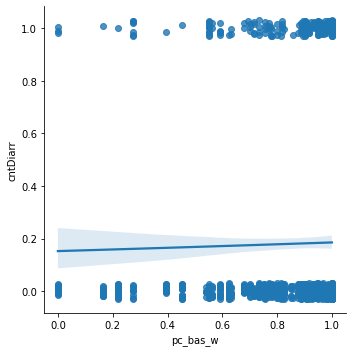

pc_bas_s


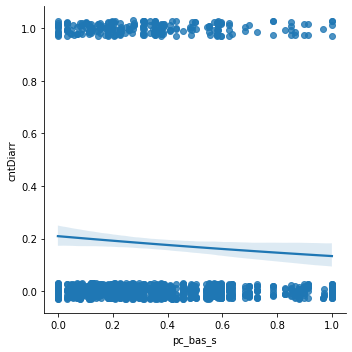

pc_Wnoed


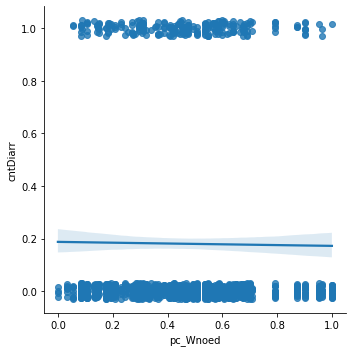

frac_100


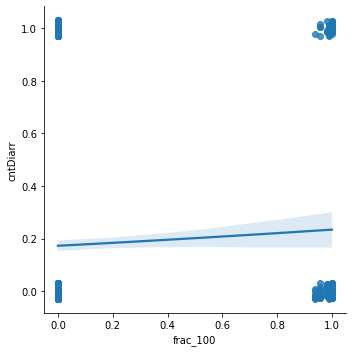

frac_40


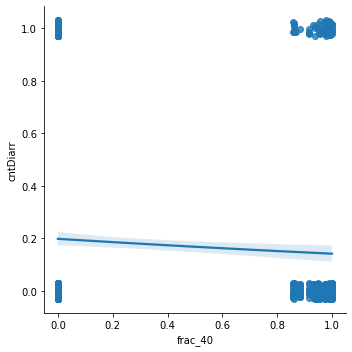

pc_HiDen


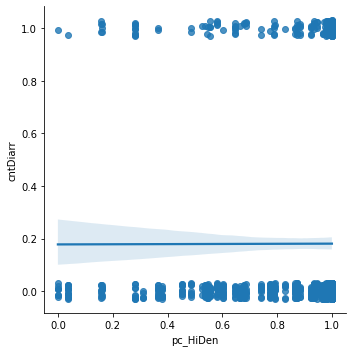

pc_b75


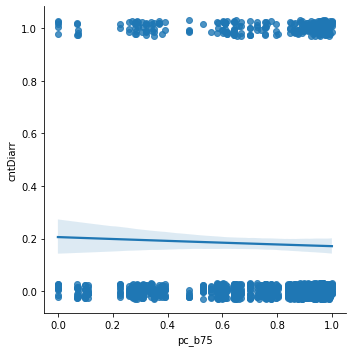

prop_19023


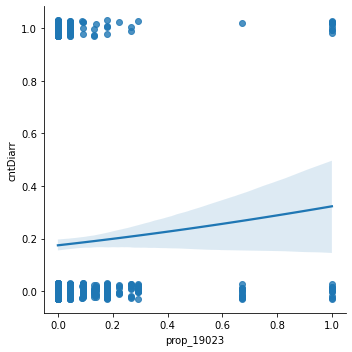

prop_4342


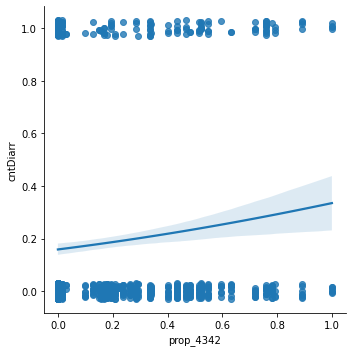

In [44]:
for var in reg_var_list:
    print(var)
    mask = (~dbf_c[var].isna())&(~dbf_c['cntDiarr'].isna())
    sns.lmplot(x=var,
               y='cntDiarr',
               data=dbf_c[mask],
               logistic=True,
               y_jitter=.03)
    plt.show()

# Logistic regression, categorical variables

In [ ]:
dbf_c = data_joined.copy()
dbf_c

In [ ]:
# Set variables

# Calculate categorical variables based on continuous variables
dbf_c['cntPrec']=np.nan
dbf_c['cntPrec'][~dbf_c['pc_PrecAr'].isna()]=0
dbf_c['cntPrec'][dbf_c['pc_PrecAr']>dbf_c['pc_PrecAr'].mean()]=1

dbf_c['cntVPrec']=np.nan
dbf_c['cntVPrec'][~dbf_c['pc_VPrcAr'].isna()]=0
dbf_c['cntVPrec'][dbf_c['pc_VPrcAr']>dbf_c['pc_VPrcAr'].mean()]=1

dbf_c['cntPrec43']=np.nan
dbf_c['cntPrec43'][~dbf_c['prop_19043'].isna()]=0
dbf_c['cntPrec43'][dbf_c['prop_19043']>dbf_c['prop_19043'].mean()]=1

dbf_c['cntFrac11']=np.nan
dbf_c['cntFrac11'][~dbf_c['frac_11'].isna()]=0
dbf_c['cntFrac11'][dbf_c['frac_11']>dbf_c['frac_11'].mean()]=1

# Set list
logreg_indvar_list = [#'cntImpW','cntBasicW',
                      'cntImpS','cntBasicS'
                      #,'cntPrec','cntVPrec','cntPrec43','cntFrac11'
                     ]

In [ ]:
# Get input data
df = dbf_c.copy()
df = df[['cntDiarr']+logreg_indvar_list]
df = df.dropna()
df

In [ ]:
# Define training sample
df_train, df_test = train_test_split(df, test_size=0.6, random_state=888, stratify=df['cntDiarr'])

print(df_train.shape)
print(df_test.shape)
print()
print(df_train['cntDiarr'].value_counts(normalize=True))
print()
print(df_test['cntDiarr'].value_counts(normalize=True))

In [ ]:
# Preprocess data for model

cat_cols = logreg_indvar_list

# Define training values
X = df_train[cat_cols].to_numpy()
y = df_train['cntDiarr']

# Define test values
X_test = df_test[cat_cols].to_numpy()
y_test = df_test['cntDiarr']

In [ ]:
# Fit model
clf = LogisticRegression(penalty='none') # logistic regression with no penalty term in the cost function.
clf.fit(X, y)

In [ ]:
# Evaluate model (using test values)

test_prob = clf.predict_proba(X_test)[:, 1]
test_pred = clf.predict(X_test)

print('Log loss = {:.5f}'.format(log_loss(y_test, test_prob)))
print('AUC = {:.5f}'.format(roc_auc_score(y_test, test_prob)))
print('Average Precision = {:.5f}'.format(average_precision_score(y_test, test_prob)))
print('\nUsing 0.5 as threshold:')
print('Accuracy = {:.5f}'.format(accuracy_score(y_test, test_pred)))
print('Precision = {:.5f}'.format(precision_score(y_test, test_pred)))
print('Recall = {:.5f}'.format(recall_score(y_test, test_pred)))
print('F1 score = {:.5f}'.format(f1_score(y_test, test_pred)))

print('\nClassification Report')
print(classification_report(y_test, test_pred))

In [ ]:
print('Confusion Matrix')
plot_confusion_matrix(clf, X_test, y_test)